In [4]:
import matplotlib.pyplot as plt
import torch as tc
from torchdiffeq import odeint
from torch import nn

In [5]:
tmin = 0
tmax = 200 #days

tspan = tc.arange(tmin, tmax).float()

N = 10**6
I0 = 1
R0 = 0
S0 = N - I0 - R0

y0 = tc.tensor([S0, I0, R0, N]).float()

In [17]:
class ODE(nn.Module):

    def __init__(self, init_params, y0):
        super(ODE, self).__init__()
        self.init_params = init_params
        self.y0 = y0
        self.params = nn.Parameter(init_params)

    def forward(self, t, y):
        S, I, R, N = y

        dS = - self.params[0] * S * I / N
        dI = self.params[0] * S * I / N - self.params[1] * I
        dR = self.params[1] * I
        dN = tc.tensor(0.0)

        return tc.stack([dS, dI, dR, dN])

In [18]:
def simulate_data(model, params, y0, tspan):
    f = model(init_params=params, y0=y0)
    with tc.no_grad():
        S, I, R, N = odeint(f, y0, tspan).T
        S = tc.distributions.Poisson(S).sample()
        I = tc.distributions.Poisson(I).sample()
        R = tc.distributions.Poisson(R).sample()

        data = tc.distributions.Poisson(f.params[0] * S * I / N).sample()
    return data

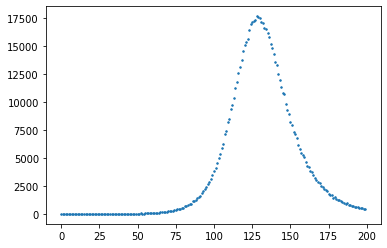

In [19]:
data = simulate_data(ODE, tc.tensor([0.2, 0.1]), y0, tspan)
plt.plot(data, '.', markersize=3)

In [20]:
def likelihood(func, data, y0, t):
    S, I, R, _ = odeint(func, y0, t, method='euler').T

    pred = func.params[0] * S * I / y0[-1]

    return (1/y0[-1]) * (pred.mean() - (1/len(t)) * tc.dot(pred.log(), data))


In [21]:
func = ODE(init_params = tc.tensor([0.5, 0.3]), y0=y0)


In [22]:
func = ODE(init_params = tc.tensor([0.5, 0.3]), y0=y0)

optimizer = tc.optim.Adam(func.parameters(), lr=0.1)

losses = []
tol = 1e-5
g = tc.tensor(1.0)
i = 0
while g > tol:
    optimizer.zero_grad()
    l = likelihood(func, data, y0, tspan)
    
    l.backward()
    if i%5==0 : print("Loss : {} , Params : {}, Grad : {} ".format(l, func.params.clone().detach(), func.params.grad))
    optimizer.step()
    g = func.params.grad.square().sum().sqrt()
    losses.append(l.clone().detach())
    i+=1

Loss : -0.0020960418041795492 , Params : tensor([0.5000, 0.3000]), Grad : tensor([ 0.3176, -0.2695]) 
Loss : -0.007476808037608862 , Params : tensor([0.4809, 0.2973]), Grad : tensor([ 0.3228, -0.2817]) 
Loss : -0.02929786406457424 , Params : tensor([0.4316, 0.3209]), Grad : tensor([ 0.2106, -0.1960]) 
Loss : -0.024280589073896408 , Params : tensor([0.3959, 0.3374]), Grad : tensor([-0.3713,  0.3633]) 
Loss : -0.0308226365596056 , Params : tensor([0.4099, 0.3070]), Grad : tensor([ 0.1318, -0.1211]) 
Loss : -0.028831271454691887 , Params : tensor([0.4089, 0.2942]), Grad : tensor([ 0.2279, -0.2117]) 
Loss : -0.03132360428571701 , Params : tensor([0.3950, 0.2956]), Grad : tensor([ 0.0836, -0.0751]) 
Loss : -0.031207874417304993 , Params : tensor([0.3823, 0.2965]), Grad : tensor([-0.1059,  0.1060]) 
Loss : -0.0309747327119112 , Params : tensor([0.3756, 0.2918]), Grad : tensor([-0.1367,  0.1355]) 
Loss : -0.03136257454752922 , Params : tensor([0.3717, 0.2844]), Grad : tensor([-0.0910,  0.0916

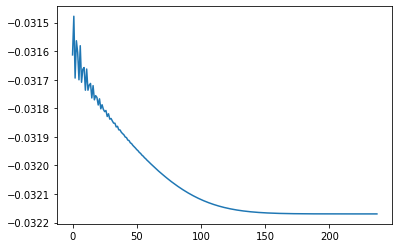

In [23]:
plt.plot(losses[50:])

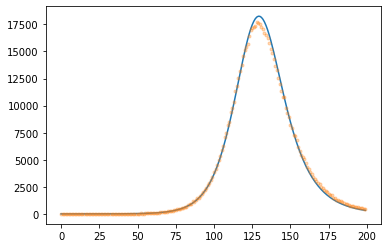

In [24]:
S, I, R, _ = odeint(func, y0, tspan, method='euler').T
pred = func.params[0] * S * I / y0[-1]
plt.plot(pred.detach())
plt.plot(data.clone().detach(), '.', alpha=0.3)